In [94]:
import pandas as pd
import numpy as np

data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

In [95]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No":"0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No":"0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


### Кодування змінних та встановлення залежних і незалежних змінних

In [96]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

le = LabelEncoder()
data1 = data.copy(deep=True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [97]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
scaler = StandardScaler()

### Функція валідації моделі

Модель випробовується на початкових даних, працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [98]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, model_scaler, balancing_method_name: str):
    global all_logreg_logs, all_dtree_logs, X, y
    
    X_initial_scaled = model_scaler.transform(X)
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_scaled, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_scaled)[:, 1]
        y_pred_initial = model.predict(X_initial_scaled)
    
    accuracy_initial = accuracy_score(y, y_pred_initial)
    precision_initial = precision_score(y, y_pred_initial)
    recall_initial = recall_score(y, y_pred_initial)
    f1_initial = f1_score(y, y_pred_initial)
    roc_auc_initial = roc_auc_score(y, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nDecision Tree")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після тренування кожної моделі виводиться лог точності моделі по **збалансованим даним**. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [99]:
def train_models(X_balanced, y_balanced, balancing_method_name: str):
    global scaler
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.35, random_state=0)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    logreg_model = train_regression_model(X_train_scaled, X_test_scaled, y_train, y_test)
    
    dtree_model = train_dtree_model(X_train_scaled, X_test_scaled, y_train, y_test)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, scaler, balancing_method_name)
    validate_model(dtree_model, scaler, balancing_method_name)

In [100]:
def train_regression_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    y_pred_log = logreg.predict(X_test_balanced)
    
    y_pred_proba_log = logreg.predict_proba(X_test_balanced)
    fpr_log, tpr_log, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_log[:,1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_log),
                             precision_score(y_test_balanced, y_pred_log, average='binary'),
                             recall_score(y_test_balanced, y_pred_log, average='binary'),
                             f1_score(y_test_balanced, y_pred_log, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_log[:,1])],
                       index=['Accuracy','Precision','Recall','F1-score','AUC'],
                       columns=["Logistic Regression"])
    print(log)
    return logreg

In [101]:
def train_dtree_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)
    y_pred_tree = dtree.predict(X_test_balanced)
    
    y_pred_proba_tree = dtree.predict_proba(X_test_balanced)
    fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_tree[:, 1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_tree),
                             precision_score(y_test_balanced, y_pred_tree, average='binary'),
                             recall_score(y_test_balanced, y_pred_tree, average='binary'),
                             f1_score(y_test_balanced, y_pred_tree, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_tree[:, 1])],
                       index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                       columns=["Decision Tree"])
    print(log)
    return dtree

### Without sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти яЯкщо модель після балансування класів буде менш точною.

In [102]:
train_models(X, y, "Without_Sampling")

           Logistic Regression
Accuracy              0.945266
Precision             0.497637
Recall                0.358740
F1-score              0.416924
AUC                   0.886588
           Decision Tree
Accuracy        0.914352
Precision       0.255478
Recall          0.297850
F1-score        0.275042
AUC             0.623877


Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score      AUC
Without_Sampling  0.944692   0.491283  0.360774  0.416034  0.88379

Decision Tree
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.970019    0.71315  0.754447  0.733218  0.868494


## Undersampling

### Random Undersampling

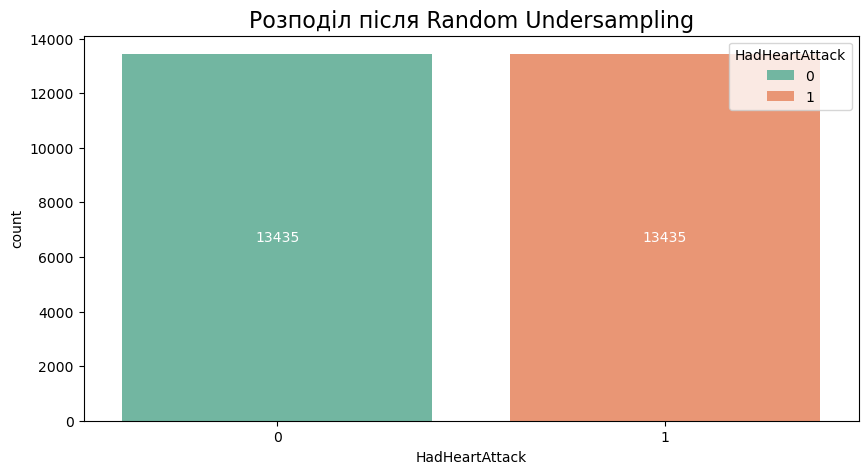

In [103]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

undersample = RandomUnderSampler(sampling_strategy='majority')
X_RUS, y_RUS = undersample.fit_resample(X, y)

plt.figure(figsize = (10,5))
ax = sns.countplot(x = y_RUS, hue = y_RUS, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Random Undersampling", size=16)
plt.show()

In [104]:
train_models(X_RUS, y_RUS, "Random_Undersampling")

           Logistic Regression
Accuracy              0.771930
Precision             0.784318
Recall                0.750478
F1-score              0.767025
AUC                   0.855504
           Decision Tree
Accuracy        0.714407
Precision       0.714013
Recall          0.715834
F1-score        0.714923
AUC             0.714406


Comparison After Validation

Logistic Regression
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling  0.796282   0.176975  0.747972  0.286227  0.857087

Decision Tree
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.970019   0.713150  0.754447  0.733218  0.868494
Random_Undersampling  0.744563   0.164366  0.900484  0.277990  0.818020


### Tomek Links

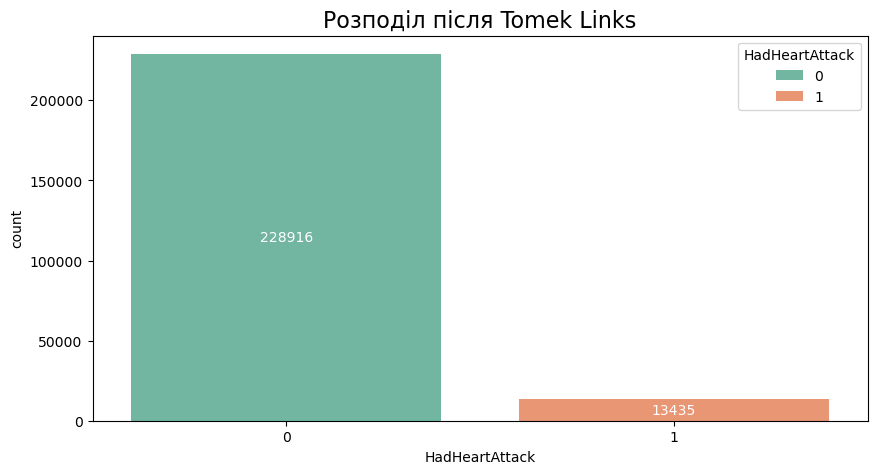

In [105]:
from imblearn.under_sampling import TomekLinks

tomek = TomekLinks()
X_TL, y_TL = tomek.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_TL, hue=y_TL, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Tomek Links", size=16)
plt.show()

In [106]:
train_models(X_TL, y_TL, "Tomek_Links")

           Logistic Regression
Accuracy              0.944402
Precision             0.500404
Recall                0.393304
F1-score              0.440437
AUC                   0.885826
           Decision Tree
Accuracy        0.914693
Precision       0.271721
Recall          0.317440
F1-score        0.292807
AUC             0.633650


Comparison After Validation

Logistic Regression
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling  0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links           0.943594   0.479850  0.391738  0.431340  0.883578

Decision Tree
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.970019   0.713150  0.754447  0.733218  0.868494
Random_Undersampling  0.744563   0.164366  0.900484  0.277990  0.818020
Tomek_Links           0.968478   0.692595  0.760179  0.724815  0.870380


### Edited Nearest Neighbours

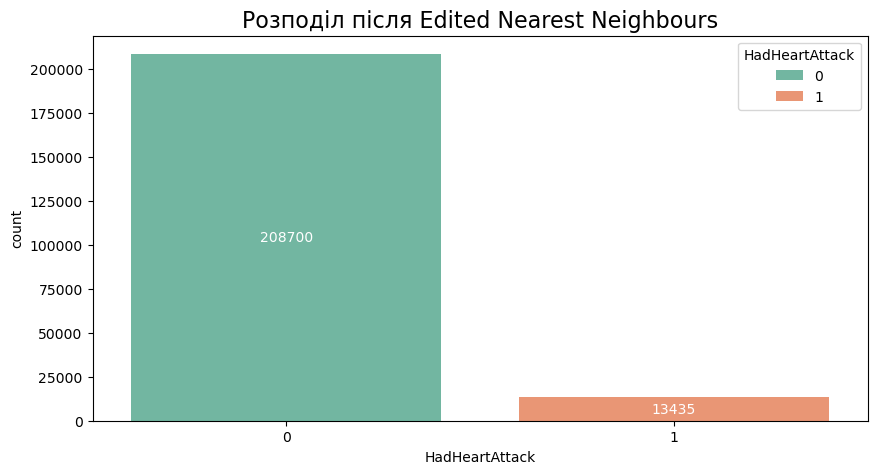

In [107]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_ENN, y_ENN = enn.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_ENN, hue=y_ENN, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Edited Nearest Neighbours", size=16)
plt.show()

In [108]:
train_models(X_ENN, y_ENN, "Edited_Nearest_Neighbours")

           Logistic Regression
Accuracy              0.943278
Precision             0.534138
Recall                0.515357
F1-score              0.524580
AUC                   0.900853
           Decision Tree
Accuracy        0.915162
Precision       0.325516
Recall          0.370472
F1-score        0.346543
AUC             0.660419


Comparison After Validation

Logistic Regression
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling       0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours  0.933502   0.411637  0.507108  0.454412  0.881913

Decision Tree
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.970019   0.713150  0.754447  0.733218  0.868494
Random_Undersampling       0.744563   0.164366  0.900484  0

### One Sided Selection

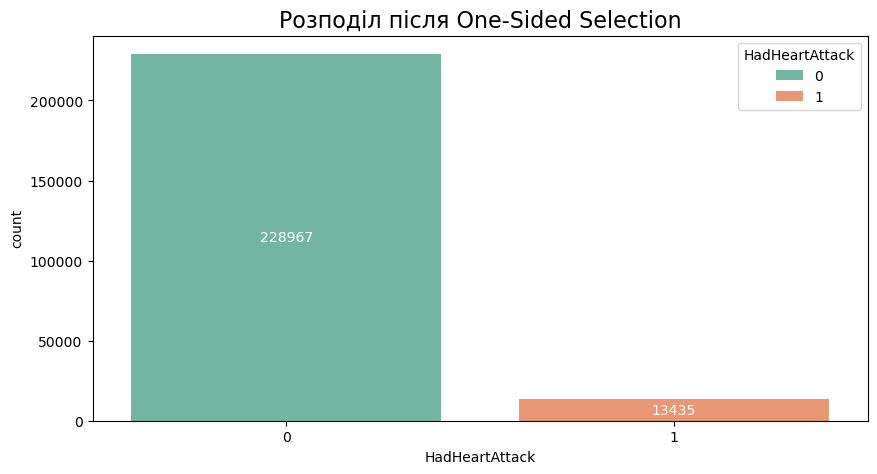

In [109]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection()
X_OSS, y_OSS = oss.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_OSS, hue=y_OSS, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після One-Sided Selection", size=16)
plt.show()

In [110]:
train_models(X_OSS, y_OSS, "One_Sided_Selection")

           Logistic Regression
Accuracy              0.943718
Precision             0.496958
Recall                0.378077
F1-score              0.429442
AUC                   0.884442
           Decision Tree
Accuracy        0.913485
Precision       0.265967
Recall          0.309278
F1-score        0.285992
AUC             0.629306


Comparison After Validation

Logistic Regression
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling       0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours  0.933502   0.411637  0.507108  0.454412  0.881913
One_Sided_Selection        0.943651   0.480137  0.385039  0.427362  0.883401

Decision Tree
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.970019   0.713150  0.754447  0

### Neighbourhood Cleaning Rule

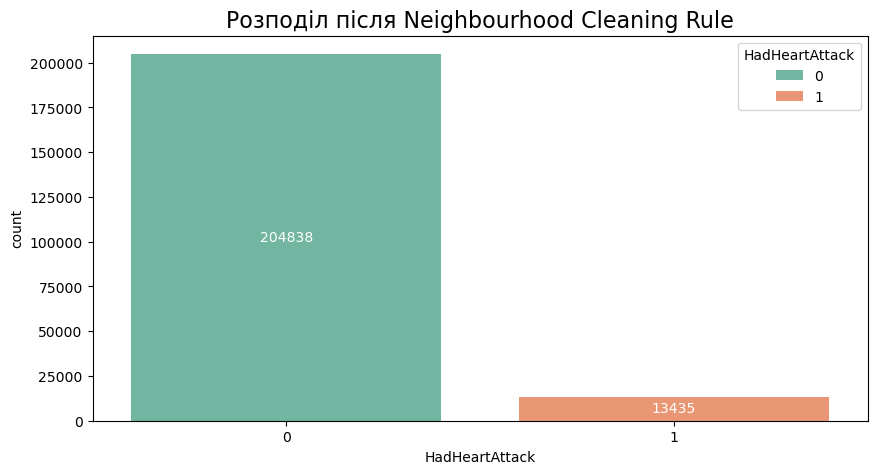

In [111]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()
X_NCR, y_NCR = ncr.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_NCR, hue=y_NCR, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Neighbourhood Cleaning Rule", size=16)
plt.show()

In [112]:
train_models(X_NCR, y_NCR, "Neighbourhood_Cleaning_Rule")

           Logistic Regression
Accuracy              0.939526
Precision             0.509584
Recall                0.491396
F1-score              0.500324
AUC                   0.897165
           Decision Tree
Accuracy        0.911239
Precision       0.309305
Recall          0.357340
F1-score        0.331592
AUC             0.652474


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling         0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                  0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours    0.933502   0.411637  0.507108  0.454412  0.881913
One_Sided_Selection          0.943651   0.480137  0.385039  0.427362  0.883401
Neighbourhood_Cleaning_Rule  0.935904   0.425048  0.492594  0.456335  0.882598

Decision Tree
                             Accuracy  Precis

### All KNN

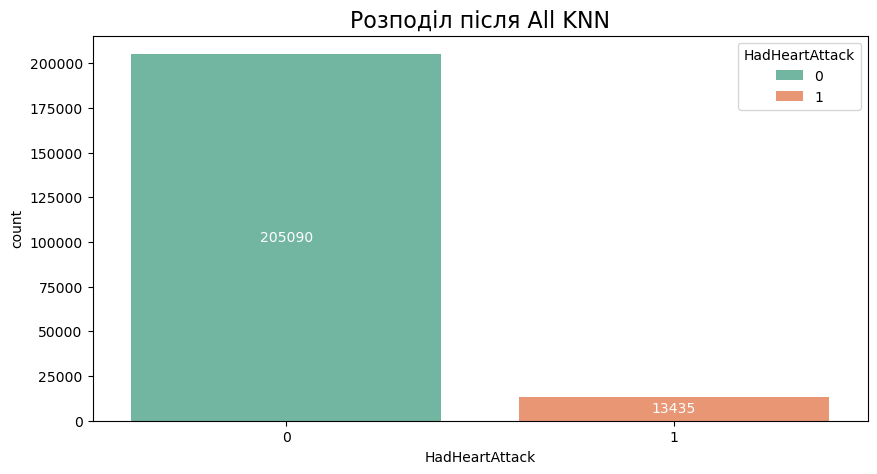

In [113]:
from imblearn.under_sampling import AllKNN

allknn = AllKNN()
X_AllKNN, y_AllKNN = allknn.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_AllKNN, hue=y_AllKNN, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після All KNN", size=16)
plt.show()

In [114]:
train_models(X_AllKNN, y_AllKNN, "All_KNN")

           Logistic Regression
Accuracy              0.939674
Precision             0.512429
Recall                0.531039
F1-score              0.521568
AUC                   0.900513
           Decision Tree
Accuracy        0.914583
Precision       0.330887
Recall          0.371199
F1-score        0.349886
AUC             0.660825


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling         0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                  0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours    0.933502   0.411637  0.507108  0.454412  0.881913
One_Sided_Selection          0.943651   0.480137  0.385039  0.427362  0.883401
Neighbourhood_Cleaning_Rule  0.935904   0.425048  0.492594  0.456335  0.882598
All_KNN                      0.928145   0.386642  0.538593  

### NearMiss

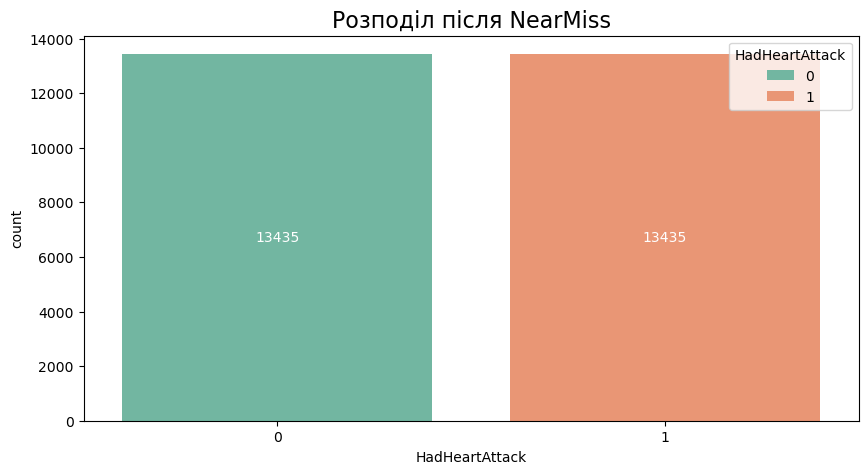

In [115]:
from imblearn.under_sampling import NearMiss

nearmiss = NearMiss()
X_NearMiss, y_NearMiss = nearmiss.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_NearMiss, hue=y_NearMiss, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після NearMiss", size=16)
plt.show()

In [116]:
train_models(X_NearMiss, y_NearMiss, "Near_Miss")

           Logistic Regression
Accuracy              0.845614
Precision             0.965646
Recall                0.716897
F1-score              0.822884
AUC                   0.942405
           Decision Tree
Accuracy        0.862095
Precision       0.867876
Recall          0.854410
F1-score        0.861090
AUC             0.862099


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling         0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                  0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours    0.933502   0.411637  0.507108  0.454412  0.881913
One_Sided_Selection          0.943651   0.480137  0.385039  0.427362  0.883401
Neighbourhood_Cleaning_Rule  0.935904   0.425048  0.492594  0.456335  0.882598
All_KNN                      0.928145   0.386642  0.538593  

### Cluster Centroids

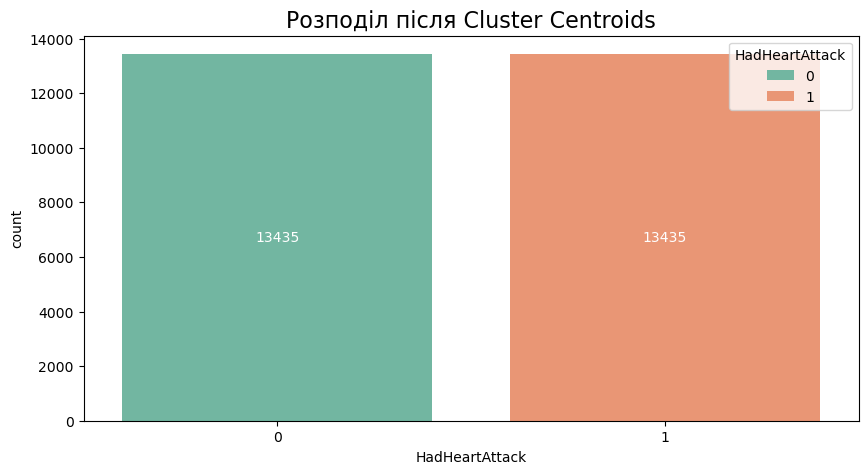

In [117]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

cc = ClusterCentroids(estimator=KMeans(n_clusters=10, random_state=42))
X_ClusterCentroids, y_ClusterCentroids = cc.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_ClusterCentroids, hue=y_ClusterCentroids, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Cluster Centroids", size=16)
plt.show()

In [118]:
train_models(X_ClusterCentroids, y_ClusterCentroids, "Cluster_Centroids")

           Logistic Regression
Accuracy              0.950877
Precision             0.964732
Recall                0.936026
F1-score              0.950162
AUC                   0.986229
           Decision Tree
Accuracy        0.964168
Precision       0.966268
Recall          0.961955
F1-score        0.964107
AUC             0.964169


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling         0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                  0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours    0.933502   0.411637  0.507108  0.454412  0.881913
One_Sided_Selection          0.943651   0.480137  0.385039  0.427362  0.883401
Neighbourhood_Cleaning_Rule  0.935904   0.425048  0.492594  0.456335  0.882598
All_KNN                      0.928145   0.386642  0.538593  

### Instance Hardness Threshold

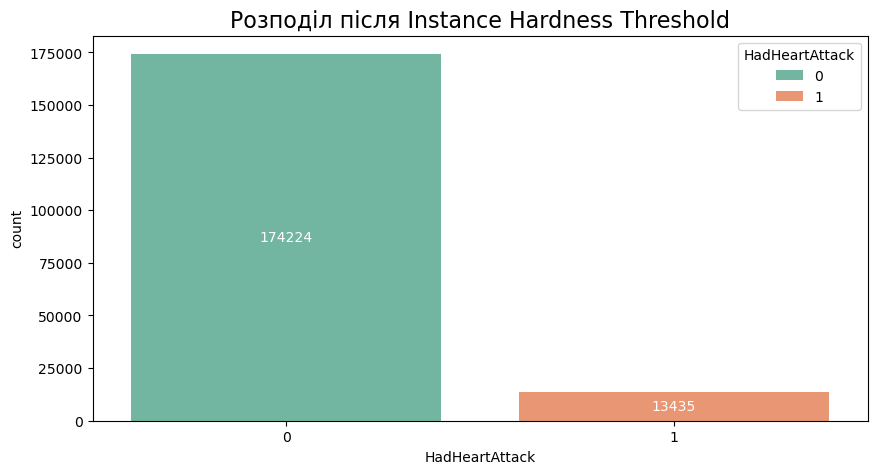

In [119]:
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.ensemble import RandomForestClassifier

iht = InstanceHardnessThreshold(estimator=RandomForestClassifier(n_estimators=10, random_state=42))
X_IHT, y_IHT = iht.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_IHT, hue=y_IHT, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Instance Hardness Threshold", size=16)
plt.show()

In [120]:
train_models(X_IHT, y_IHT, "Instance_Hardness_Threshold")

           Logistic Regression
Accuracy              0.948615
Precision             0.641306
Recall                0.680290
F1-score              0.660223
AUC                   0.934006
           Decision Tree
Accuracy        0.938430
Precision       0.574846
Recall          0.618257
F1-score        0.595762
AUC             0.791022


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.944692   0.491283  0.360774  0.416034  0.883790
Random_Undersampling         0.796282   0.176975  0.747972  0.286227  0.857087
Tomek_Links                  0.943594   0.479850  0.391738  0.431340  0.883578
Edited_Nearest_Neighbours    0.933502   0.411637  0.507108  0.454412  0.881913
One_Sided_Selection          0.943651   0.480137  0.385039  0.427362  0.883401
Neighbourhood_Cleaning_Rule  0.935904   0.425048  0.492594  0.456335  0.882598
All_KNN                      0.928145   0.386642  0.538593  

### Висновки

Можна бачити, що практично жодна техніка undersampling не дала збільшення точності моделі. Думаю, це можна було б пояснити малою кількістю зразків меншості, що складає всьго близько 14тис. записів. Моделі просто недостатньо цих даних. 
У випадку з техніками, що прибирають шуми, як ось **Tomek Links, Edited Nearest Neighbours, One Sided Selection, Neighbourhood Cleaning Rule, AllKnn та Instance Hardness Threshold** відсутність приросту точності можна пояснити відсутні